# [Wilson-Cowan SDE model in Numba](https://github.com/Ziaeemehr/vbi_paper/blob/main/docs/examples/wilson_cowan_sde_numba_cde.ipynb)
- sweep and inference with MAF


<a href="https://colab.research.google.com/github/Ziaeemehr/vbi_paper/blob/main/docs/examples/wilson_cowan_sde_numba_cde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<br>
Imports & global config<br>


In [149]:
import os
import warnings
warnings.filterwarnings("ignore")

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from copy import deepcopy
from scipy.signal import welch

In [151]:
import vbi
from vbi.cde import MAFEstimator
from vbi.models.numba.wilson_cowan import WC_sde

Reproducibility and paths

In [152]:
GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)

In [153]:
OUTPUT_DIR = "output/wilson_cowan_sde_numba_cde_"
os.makedirs(OUTPUT_DIR, exist_ok=True)

Matplotlib font sizes

In [ ]:
LABEL_SIZE = 10
plt.rcParams["axes.labelsize"] = LABEL_SIZE
plt.rcParams["xtick.labelsize"] = LABEL_SIZE
plt.rcParams["ytick.labelsize"] = LABEL_SIZE

<br>
Frequency control tips (for reference)<br>
<br>
To shift oscillation frequency:<br>
1) Coupling strengths (weights)   2) Time constants<br>
3) External inputs                4) Refractory periods<br>
5) Sigmoid parameters

<br>
Sweep over external input P (2-node toy network)<br>


In [154]:
N_SWEEP = 30
P_grid = np.linspace(0.0, 3.0, N_SWEEP)

In [155]:
W_conn = np.array([[0, 1],
                   [1, 0]], dtype=np.float32)

In [156]:
params = dict(
    weights=W_conn,
    dt=0.1,
    t_end=2000.0,
    t_cut=101.0,
    noise_amp=0.001,
    g_e=0.0,
    g_i=0.0,
    P=1.22,
    RECORD_EI="EI",
    decimate=1,
    seed=GLOBAL_SEED,
)

In [157]:
def run_wc_with_P(params_dict: dict, P_value: float):
    """Run Wilson–Cowan SDE once with a specific external drive P."""
    sim = WC_sde(params_dict)
    sol = sim.run({"P": P_value})
    return sol

Parallel sweep

In [158]:
with mp.Pool(processes=4) as pool:
    sweep_results = pool.starmap(run_wc_with_P, [(params, p) for p in P_grid])
    sweep_results = [sol for sol in sweep_results if sol is not None]

In [159]:
t = sweep_results[0]["t"]
E_traces = np.array([sol["E"] for sol in sweep_results])
I_traces = np.array([sol["I"] for sol in sweep_results])

In [160]:
print(t.shape, E_traces.shape, I_traces.shape)  # (ntime,) (nsim, ntime, nnodes) (nsim, ntime, nnodes)

(18990,) (30, 18990, 2) (30, 18990, 2)


<br>
Visualize sweep: time series, spectra, and phase portrait<br>


Welch PSD across sweep for node 0

In [161]:
freq, psd_E = welch(
    E_traces[:, :, 0],
    fs=1 / (params["dt"] * params["decimate"]) * 1000,
    nperseg=8 * 1024,
    axis=1,
)

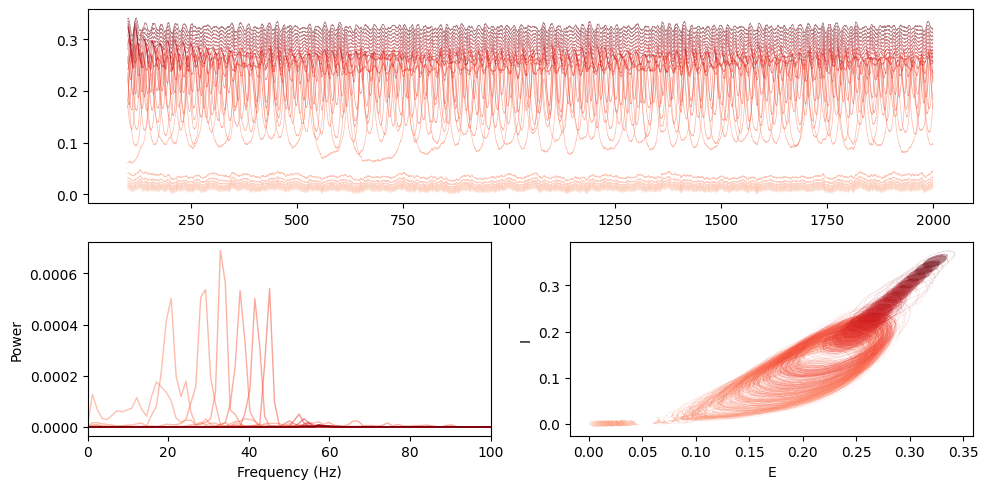

In [162]:
mosaic = """
AA
BC
"""
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
axs = fig.subplot_mosaic(mosaic)

colors = plt.cm.Reds(np.linspace(0.1, 1.0, N_SWEEP))

# Time series (E, node 0)
for i in range(N_SWEEP):
    axs["A"].plot(t, E_traces[i, :, 0], alpha=0.5, lw=0.5, color=colors[i])

# Spectra (E, node 0)
for i in range(N_SWEEP):
    axs["B"].plot(freq, psd_E[i, :], alpha=0.5, lw=1, color=colors[i], label=f"{P_grid[i]:.2f}")

# Phase portrait (E vs I, node 0)
for i in range(N_SWEEP):
    axs["C"].plot(E_traces[i, :, 0], I_traces[i, :, 0], lw=0.1, alpha=0.5, color=colors[i])

axs["B"].set_xlabel("Frequency (Hz)")
axs["B"].set_ylabel("Power")
axs["B"].set_xlim(0, 100)
axs["C"].set_xlabel("E")
axs["C"].set_ylabel("I")
plt.tight_layout()

Peak frequency vs P

In [163]:
peak_idx = np.argmax(psd_E, axis=1)
f_peak = freq[peak_idx]

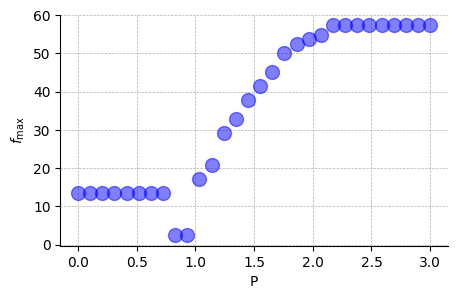

In [164]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(P_grid, f_peak, "bo", ms=10, alpha=0.5)
ax.grid(True, ls="--", lw=0.5)
ax.set_xlabel("P")
ax.set_ylabel(r"$f_{\max}$")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

<br>
Single run (cleaner visualization)<br>


In [165]:
W_conn = np.array([[0, 1],
                   [1, 0]], dtype=np.float32)
P0 = 1.025

In [166]:
params_single = {
    "g_e": 0.0,
    "seed": 42,
    "dt": 0.05,
    "t_end": 2000.0,
    "t_cut": 101.0,
    "noise_amp": 0.0005,  # small noise
    "decimate": 1,
    "P": P0,
    "RECORD_EI": "EI",
    "weights": W_conn,
}

In [167]:
sim_single = WC_sde(params_single)
sol_single = sim_single.run()
t1 = sol_single["t"]
E1 = sol_single["E"]
I1 = sol_single["I"]

In [168]:
print(t1.shape, E1.shape, I1.shape)

(37980,) (37980, 2) (37980, 2)


In [169]:
fE, psd_E1 = welch(
    E1,
    fs=1 / (params_single["dt"] * params_single["decimate"]) * 1000,
    nperseg=5 * 1024,
    axis=0,
)
fI, psd_I1 = welch(
    I1,
    fs=1 / (params_single["dt"] * params_single["decimate"]) * 1000,
    nperseg=5 * 1024,
    axis=0,
)

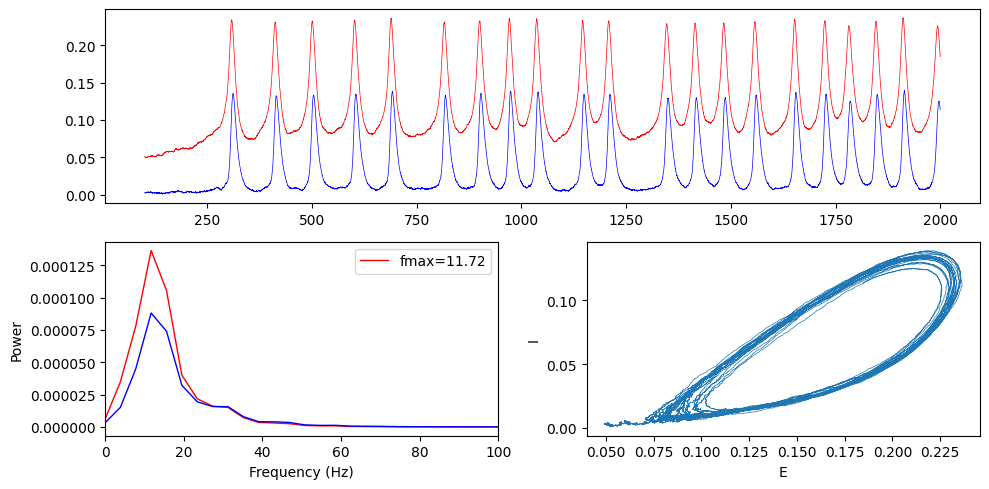

In [170]:
mosaic = """
AA
BC
"""
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
axs = fig.subplot_mosaic(mosaic)

axs["A"].plot(t1, E1[:, 0], label="E", color="red", alpha=1, lw=0.5)
axs["A"].plot(t1, I1[:, 0], label="I", color="blue", alpha=1, lw=0.5)

axs["B"].plot(fE, psd_E1[:, 0], label="E", color="red", alpha=1, lw=1)
axs["B"].plot(fI, psd_I1[:, 0], label="I", color="blue", alpha=1, lw=1)
axs["B"].set_xlabel("Frequency (Hz)")
axs["B"].set_ylabel("Power")
axs["B"].set_xlim(0, 100)

axs["C"].plot(E1[:, 0], I1[:, 0], lw=0.5)
axs["C"].set_xlabel("E")
axs["C"].set_ylabel("I")

f_max_single = fE[np.argmax(psd_E1[:, 0])]
axs["B"].legend([f"fmax={f_max_single:.2f}"])
plt.tight_layout()


<br>
Inference setup (goal: estimate global coupling g_e)<br>


In [171]:
from vbi import (
    report_cfg,
    update_cfg,
    extract_features,
    extract_features_df,
    get_features_by_domain,
    get_features_by_given_names,
)
from helpers import *  # keep as in original script

In [172]:
INFER_SEED = 2
np.random.seed(INFER_SEED)

Structural connectivity from the VBI sample

In [173]:
D_loader = vbi.LoadSample(nn=84)
W_empirical = D_loader.get_weights()
n_nodes = W_empirical.shape[0]
print(f"number of nodes: {n_nodes}")

number of nodes: 84


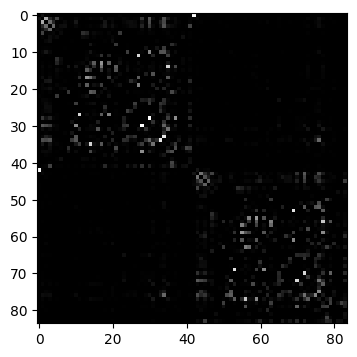

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4.5))
ax.imshow(W_empirical, cmap="gray", vmin=0, vmax=1);

Base params for inference simulations

In [176]:
params_inf = dict(
    weights=W_empirical,
    dt=0.1,
    t_end=2000.0,
    t_cut=101.0,
    noise_amp=0.001,
    g_e=0.0,
    g_i=0.0,
    P=1.22,
    RECORD_EI="EI",
    decimate=1,
    seed=INFER_SEED,
)

In [177]:
wc_model = WC_sde(params_inf)
print(wc_model)

Wilson-Cowan (Numba) parameters:
nn = 84
dt = 0.1
t_end = 2000.0
t_cut = 101.0
decimate = 1
noise_amp = 0.001
g_e = 0.0
g_i = 0.0
a_e = 1.3
a_i = 2.0
b_e = 4.0
b_i = 3.7
k_e = 0.994
k_i = 0.999


<br>
Feature extraction config (spectral stats via Welch)<br>


In [178]:
def preprocess(x):
    """Optional preprocessing hook (here: identity)."""
    # x = x - np.mean(x, axis=1, keepdims=True)
    return x

In [179]:
def simulate_to_features(params_dict: dict, ge_value: float, cfg, return_labels: bool = False):
    """
    Run WC SDE with a given g_e, then extract feature vector for E.
    """
    sde = WC_sde(params_dict)
    sim = sde.run({"g_e": ge_value})
    stat_vec = extract_features(
        [sim["E"].T],
        fs=1.0 / params_dict["dt"] / params_dict["decimate"],
        cfg=cfg,
        preprocess=preprocess,
        preprocess_args={},
        n_workers=1,
        verbose=False,
    )
    values = stat_vec.values  # shape: (1, n_features)
    if return_labels:
        return values[0], stat_vec.labels
    return values[0]

Build a spectral config focused on summary stats

In [180]:
nperseg = 1024
cfg = get_features_by_domain(domain="spectral")
cfg = get_features_by_given_names(cfg, names=["spectrum_stats"])
cfg = update_cfg(
    cfg,
    "spectrum_stats",
    parameters={
        "fs": 1.0 / (params_inf["dt"] * params_inf["decimate"]) * 1000,
        "method": "welch",
        "nperseg": nperseg,
        "average": True,
    },
)
report_cfg(cfg)

Selected features:
------------------
■ Domain: spectral
 ▢ Function:  spectrum_stats
   ▫ description:  Computes the spectrum of the signal.
   ▫ function   :  vbi.feature_extraction.features.spectrum_stats
   ▫ parameters :  {'fs': 10000.0, 'nperseg': 1024, 'indices': None, 'verbose': False, 'average': True, 'method': 'welch', 'features': ['spectral_distance', 'fundamental_frequency', 'max_frequency', 'max_psd', 'median_frequency', 'spectral_centroid', 'spectral_kurtosis', 'spectral_variation']}
   ▫ tag        :  all
   ▫ use        :  yes


<br>
Batch simulations → features  (with LOAD_DATA switch)<br>


In [181]:
from vbi.utils import BoxUniform
import tqdm

Prior over g_e

In [182]:
N_SIM = 500
g_min, g_max = 0.0, 1.0
prior = BoxUniform(low=[g_min], high=[g_max])
theta = prior.sample((N_SIM,), seed=INFER_SEED).astype(np.float32)  # (N_SIM, 1)

Toggle this to skip recomputation and load saved features instead

In [185]:
LOAD_DATA = True # set to False to regenerate data, load otherwise if available
SIM_DATA_PATH = os.path.join(OUTPUT_DIR, "simulated_data.npz")

In [186]:
def run_batch_features(params_dict: dict, theta_values: np.ndarray, cfg, n_workers: int = -1):
    """
    Parallel feature extraction across theta samples.
    Returns a list of feature vectors.
    """
    def _tick(_):
        pbar.update()
    n = len(theta_values)
    with mp.Pool(processes=n_workers) as pool:
        with tqdm.tqdm(total=n) as pbar:
            async_results = [
                pool.apply_async(
                    simulate_to_features,
                    args=(params_dict, float(theta_values[i]), cfg),
                    callback=_tick,
                )
                for i in range(n)
            ]
            return [r.get() for r in async_results]

Compute or load features

In [187]:
if LOAD_DATA and os.path.exists(SIM_DATA_PATH):
    data = np.load(SIM_DATA_PATH, allow_pickle=True)
    X_features = data["X"]
    theta = data["theta"]
    feature_labels = list(data["labels"])
    print(f"Loaded features from {SIM_DATA_PATH} → X shape {X_features.shape}")
else:
    feature_example, feature_labels = simulate_to_features(params_inf, float(theta[0]), cfg, return_labels=True)
    print(np.array(feature_example).shape)
    print(feature_labels)
    X_list = run_batch_features(params_inf, theta, cfg, n_workers=10)
    X_features = np.array(X_list)
    np.savez(SIM_DATA_PATH, theta=theta, X=X_features, labels=np.array(feature_labels, dtype=object))
    print(f"Saved features to {SIM_DATA_PATH} → X shape {X_features.shape}")

(8,)
['spectral_distance_0', 'fundamental_frequency_0', 'max_frequency_0', 'max_psd_0', 'median_frequency_0', 'spectral_centroid_0', 'spectral_kurtosis_0', 'spectral_variation_0']


100%|██████████| 500/500 [00:36<00:00, 13.77it/s]

Saved features to output/wilson_cowan_sde_numba_cde_/simulated_data.npz → X shape (500, 8)


Quick diagnostics: feature vs g_e

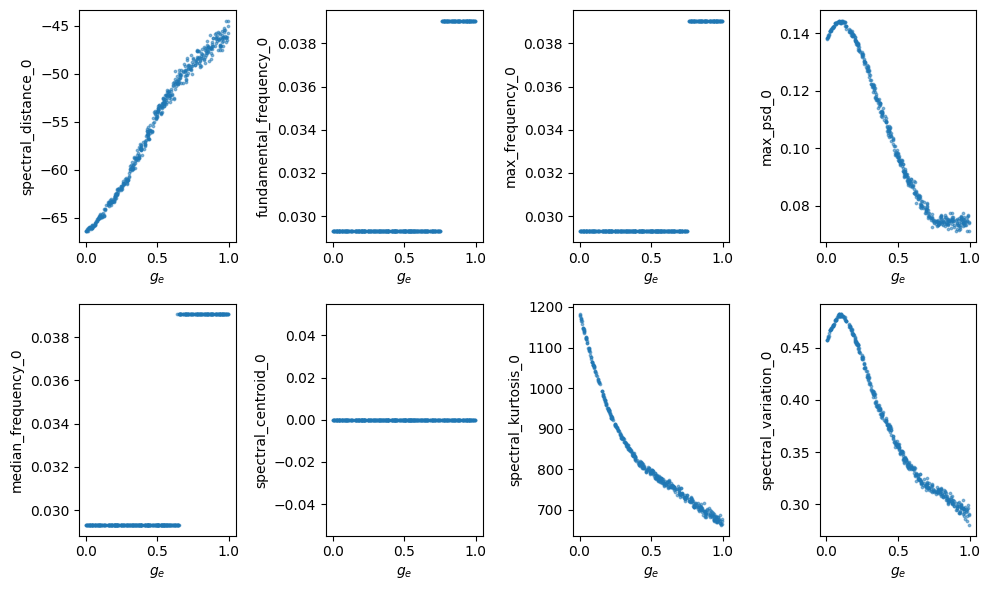

In [188]:
fig, axes = plt.subplots(2, 4, figsize=(10, 6))
axes = axes.flatten()
for i in range(min(len(axes), X_features.shape[1])):
    axes[i].scatter(theta, X_features[:, i], s=3, alpha=0.5)
    axes[i].set_xlabel(r"$g_e$")
    axes[i].set_ylabel(feature_labels[i])
plt.tight_layout()

<br>
Feature filtering (drop near-constant features)<br>


In [189]:
import pandas as pd

In [190]:
df_features = pd.DataFrame(X_features, columns=feature_labels)
remaining_features = df_features.columns[df_features.var() > 1e-5].tolist()
remaining_idxs = [df_features.columns.get_loc(col) for col in remaining_features]

In [191]:
print("Kept features:", remaining_features)

Kept features: ['spectral_distance_0', 'fundamental_frequency_0', 'max_frequency_0', 'max_psd_0', 'median_frequency_0', 'spectral_kurtosis_0', 'spectral_variation_0']


In [192]:
theta_true = 0.27
x_observed = simulate_to_features(params_inf, theta_true, cfg)[remaining_idxs]

In [193]:
print(x_observed.shape, X_features[:, remaining_idxs].shape)

(7,) (500, 7)


<br>
Train MAF estimator and analyze posterior<br>


In [194]:
from vbi.utils import posterior_shrinkage_numpy, posterior_zscore_numpy
import autograd.numpy as anp

In [195]:
rng = anp.random.RandomState(INFER_SEED)
maf = MAFEstimator(n_flows=4, hidden_units=64)

In [196]:
maf.train(
    theta.astype(np.float32),
    X_features[:, remaining_idxs].astype(np.float32),
    n_iter=500,
    learning_rate=2e-4,
)

Inferred dimensions: param_dim=1, feature_dim=7


Training: 100%|██████████| 500/500 [00:10<00:00, 45.61it/s, patience=0/20, train=-2.0224, val=-2.3031]


In [197]:
n_samples = 5000
samples = maf.sample(x_observed, n_samples=n_samples, rng=rng)[0]

In [198]:
shrinkage = posterior_shrinkage_numpy(theta, samples)
zscore = posterior_zscore_numpy(theta_true, samples)

In [199]:
print("True parameters:      ", theta_true)
print("MAF mean estimate:    ", np.mean(samples, axis=0))
print("Posterior shrinkage:  ", np.array2string(shrinkage, precision=3, separator=", "))
print("Posterior z-score:    ", np.array2string(zscore, precision=3, separator=", "))

True parameters:       0.27
MAF mean estimate:     [0.26878434]
Posterior shrinkage:   [1.]
Posterior z-score:     [0.276]


In [200]:
from vbi.plot import pairplot_numpy

In [201]:
limits = [(g_min, g_max)]
points = np.array(theta_true).reshape(1, -1)

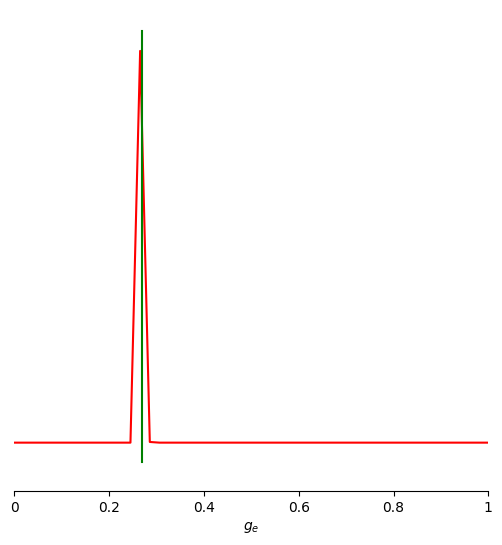

In [202]:
fig, ax = pairplot_numpy(
    samples=samples,
    limits=limits,
    points=points,
    figsize=(8, 6),
    labels=[r"$g_e$"],
    diag="kde",
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=5),
        points_colors=["g"],
    ),
    diag_kwargs={"mpl_kwargs": {"color": "r"}},
    upper_kwargs={"mpl_kwargs": {"cmap": "Blues"}},
)